#### Import libraries

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split
np.random.seed(0)

#### Import data

In [13]:
# load boston housing prices dataset
boston = load_boston()
features = boston.feature_names
x = boston['data']
N = x.shape[0]
d = x.shape[1]
y = boston['target']

#### Visulize features

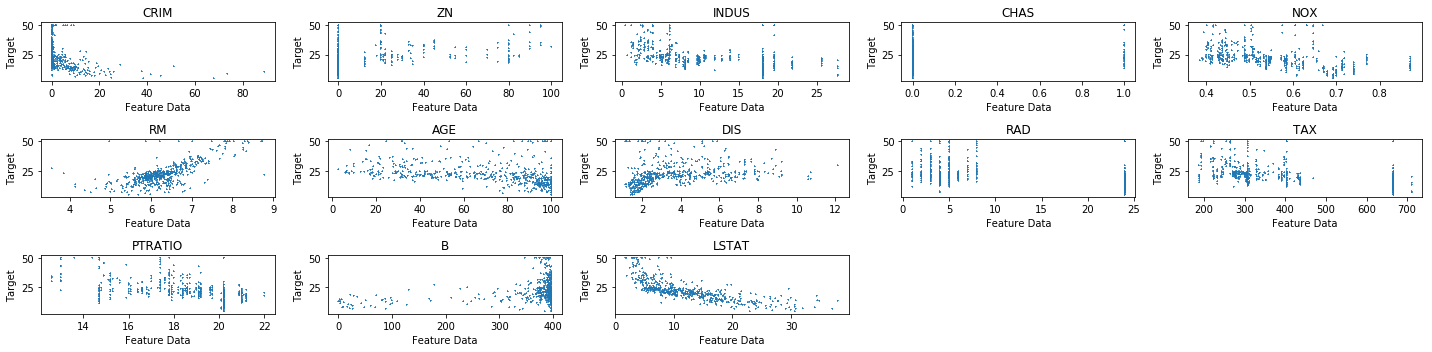

In [14]:
plt.figure(figsize=(20, 5))
feature_count = x.shape[1]

# i: index
for i in range(feature_count):
    plt.subplot(3, 5, i + 1)
    #TODO: Plot feature i against y
    plt.scatter(x[:,i], y, marker="+", s=np.ones(503))
    plt.title("{}".format(features[i]))
    plt.xlabel("Feature Data")
    plt.ylabel("Target")


plt.tight_layout()
plt.show()

#### Methods to do locally weighted least square regression

In [15]:

def l2(A, B):
    '''
    Input: A is a Nxd matrix
           B is a Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between A[i,:] and B[j,:]
    i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
    '''
    A_norm = (A**2).sum(axis=1).reshape(A.shape[0],1)
    B_norm = (B**2).sum(axis=1).reshape(1,B.shape[0])
    dist = A_norm+B_norm-2*A.dot(B.transpose())
    return dist
 

def LRLS(test_datum, x_train, y_train, tau, lam=1e-5):
    '''
    Given a test datum, it returns its prediction based on locally weighted regression

    Input: test_datum is a dx1 test vector
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           tau is the local reweighting parameter
           lam is the regularization parameter
    output is y_hat the prediction on test_datum
    '''
    
    td = np.transpose(test_datum)
    x_test = -l2(td, x_train)/ (2 * (tau ** 2))
    log_alphas = x_test - logsumexp(x_test)

    alphas = np.exp(log_alphas)

    xt_transpose = np.transpose(x_train)
    left = np.matmul(xt_transpose * alphas, x_train)
    right = np.matmul(xt_transpose * alphas, y_train)
    
    weights = np.linalg.solve(left + (10**-8 * np.eye(left.shape[0])), right)
    

    return np.dot(weights, test_datum)
    
    
    


def run_on_fold(x_test, y_test, x_train, y_train, taus):
    '''
    Input: x_test is the N_test x d design matrix
           y_test is the N_test x 1 targets vector        
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           taus is a vector of tau values to evaluate
    output: losses a vector of average losses one for each tau value
    '''
    N_test = x_test.shape[0]
    losses = np.zeros(taus.shape)
    for j,tau in enumerate(taus):
        placeholder = [LRLS(x_test[i,:].reshape(d,1),x_train,y_train, tau) \
                        for i in range(N_test)]
        predictions =  np.array(placeholder)
        losses[j] = ((predictions.flatten()-y_test.flatten())**2).mean()
    return losses


def run_k_fold(x, y, taus, k):
    '''
    Input: x is the N x d design matrix
           y is the N x 1 targets vector    
           taus is a vector of tau values to evaluate
           K in the number of folds
    output is losses a vector of k-fold cross validation losses one for each tau value
    '''
    
    kfold = KFold(k, shuffle=True)
    losses = []
    for train, test in kfold.split(x):
        x_train, x_test = x[train], x[test]
        y_train, y_test = y[train], y[test]
        loss = run_on_fold(x_test, y_test, x_train, y_train, taus)
        losses.append(loss)
    
    return np.sum(losses, axis=0)/k
    




----- fitting models on 5 k folds -----
----- fitting completed -----
----- plotting error vs tau ----


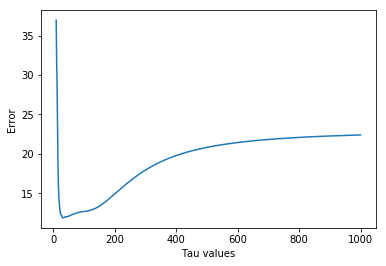

min loss = 11.895148018197492


In [18]:
x = np.concatenate((np.ones((506,1)),x),axis=1) #add constant one feature - no bias needed
d = x.shape[1]
taus = np.logspace(1.0,3,200)
divid = len(taus) //5

print("----- fitting models on 5 k folds -----")
losses = run_k_fold(x,y,taus,k=5)
print("----- fitting completed -----")
print("----- plotting error vs tau ----")

plt.plot(taus, losses)
plt.ylabel("Error")
plt.xlabel("Tau values")
plt.show()

print("min loss = {}".format(np.asarray(losses).flatten().min()))   
